# Lecture 4, figures

This is the code for generating the figures in lecture 4 - the base code is from Lab 4, Iterated Bayesian Learning

## Lab 4 code

In [1]:
from math import log, exp

In [2]:
import random
from scipy.stats import beta
from scipy.special import logsumexp
from math import log, log1p, exp

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
def log_subtract(x,y):
    """Takes two log numbers; returns their difference."""
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    """Takes a list of log numbers; returns a list of scaled versions of those numbers that, 
    once converted to probabilities, sum to 1."""
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                           #is equivalent to dividing in the normal domain
    return normedlogs

def log_roulette_wheel(normedlogs):
    """Takes a list of normed log probabilities; returns some index of that list 
    with probability corresponding to the (exponentiated) value of that list element"""
    r=log(random.random()) #generate a random number between 0 and 1, then convert to log
    accumulator = normedlogs[0] 
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

In [4]:
grid_granularity = 100
grid_increment = 1 / grid_granularity
 
# sets up the grid of possible probabilities to consider
possible_pW1 = []
for i in range(grid_granularity):
    possible_pW1.append(grid_increment / 2 + (grid_increment * i))

# sets up the grid of log probabilities
possible_logpW1 = []
for pW1 in possible_pW1:
    possible_logpW1.append(log(pW1))

In [5]:
def calculate_logprior(alpha, possible_pW1):
    """Takes in the shape parameter of a symmetrical beta distribution, and list of possible probabilities for word 1;
    returns a list of log prior probabilities, one per element in our hypothesis space."""
    logprior = []
    for pW1 in possible_pW1:
        logprior.append(beta.logpdf(pW1, alpha, alpha)) 
    return normalize_logprobs(logprior) 

In [6]:
def loglikelihood(data, logpW1):
    """Takes data (list of numbers) and hypothesis (a single log probability);
       returns the log probability of the given hypothesis generating the observed data."""
    logpW0 = log_subtract(log(1), logpW1) #probability of w0 is 1-prob of w1
    logprobs = [logpW0, logpW1]
    loglikelihoods = []
    for d in data:
        loglikelihood_this_item = logprobs[d] #d will be either 0 or 1, 
                                              #so can use as index
        loglikelihoods.append(loglikelihood_this_item)
    return sum(loglikelihoods) #summing log probabilities = 
                               #multiply non-log probabilities
    
def logproduce(logpW1, n_productions):
    """Takes log probability of word 1 being produced and the number of productions to generate;
       returns list of numbers (0 or 1), with 1 sampled with the log probability given in logpW1"""
    logpW0 = log_subtract(log(1), logpW1)
    logprobs = [logpW0, logpW1]
    data = []
    for p in range(n_productions):
        data.append(log_roulette_wheel(logprobs))
    return data

In [7]:
def logposterior(data, logprior, possible_pW1):
    """Takes data (list of numbers), logprior (list of log prior probabilities for each hypothesis),
        and a list of possible probabilities of word 1;
       returns list of log probabilities, one per hypothesis."""
    posterior_logprobs = []
    for i in range(len(possible_pW1)):
        logpW1 = log(possible_pW1[i]) 
        logp_h = logprior[i] #prior probability of this pW1
        logp_d = loglikelihood(data, logpW1) #likelihood of data given this pW1
        posterior_logprobs.append(logp_h + logp_d) #adding logs = 
                                                   #multiplying non-logs
    return normalize_logprobs(posterior_logprobs) 
     
def loglearn(data,logprior, possible_pW1):
    """Takes data (list of numbers), logprior (list of log prior probabilities for each hypothesis),
         and a list of possible probabilities of word 1;
       Returns a single hypothesis, selected proportional to its posterior log probability."""
    posterior_logprobs = logposterior(data, logprior, possible_pW1)
    selected_index = log_roulette_wheel(posterior_logprobs)
    return possible_logpW1[selected_index]

In [8]:
def iterate(alpha, possible_pW1, n_productions, starting_count_w1, generations):
    """
    Arguments:
        alpha: number that defines the shape of the beta distribution
        possible_pW1: the hypothesis space (possible probabilities for word 1)
        n_productions: number of productions in each generation
        starting_count_w1: number of times w1 was produced in the first generation
        generations: number of generations to run the simulation for
    Returns:
        A tuple containing pW1_accumulator (the generation-by-generation record of inferred pW1s)
        and data_accumulator (the generation-by-generation record of the number of w1s produced)
    """
    prior = calculate_logprior(alpha, possible_pW1)
    pW1_accumulator = [] # we build up lists of our inferred pW1 at each generation
    data_accumulator = [] # and number of produced word1 at each generation
    data = [1] * starting_count_w1 + [0] * (n_productions - starting_count_w1)
    for generation in range(generations):
        logpW1 = loglearn(data, prior, possible_pW1)
        data = logproduce(logpW1, n_productions)
        pW1_accumulator.append(exp(logpW1)) # will convert the inferred pW1 to a normal probability for you!
        data_accumulator.append(sum(data))
    return pW1_accumulator, data_accumulator

OK, build some learner data: I wamnt to be able to show a learner learner from data generated with `pW1`=60%, how their posterior looks after each additional data item.

In [9]:
data = [[]]
for i in range(1,101):
    next_data = logproduce(log(0.6),1)
    data.append(data[i-1]+logproduce(log(0.6),1))
print(data[-1])
sum(data[-1])

[0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1]


58

This will generate a video, each frame shows the posterior from a successive data set.

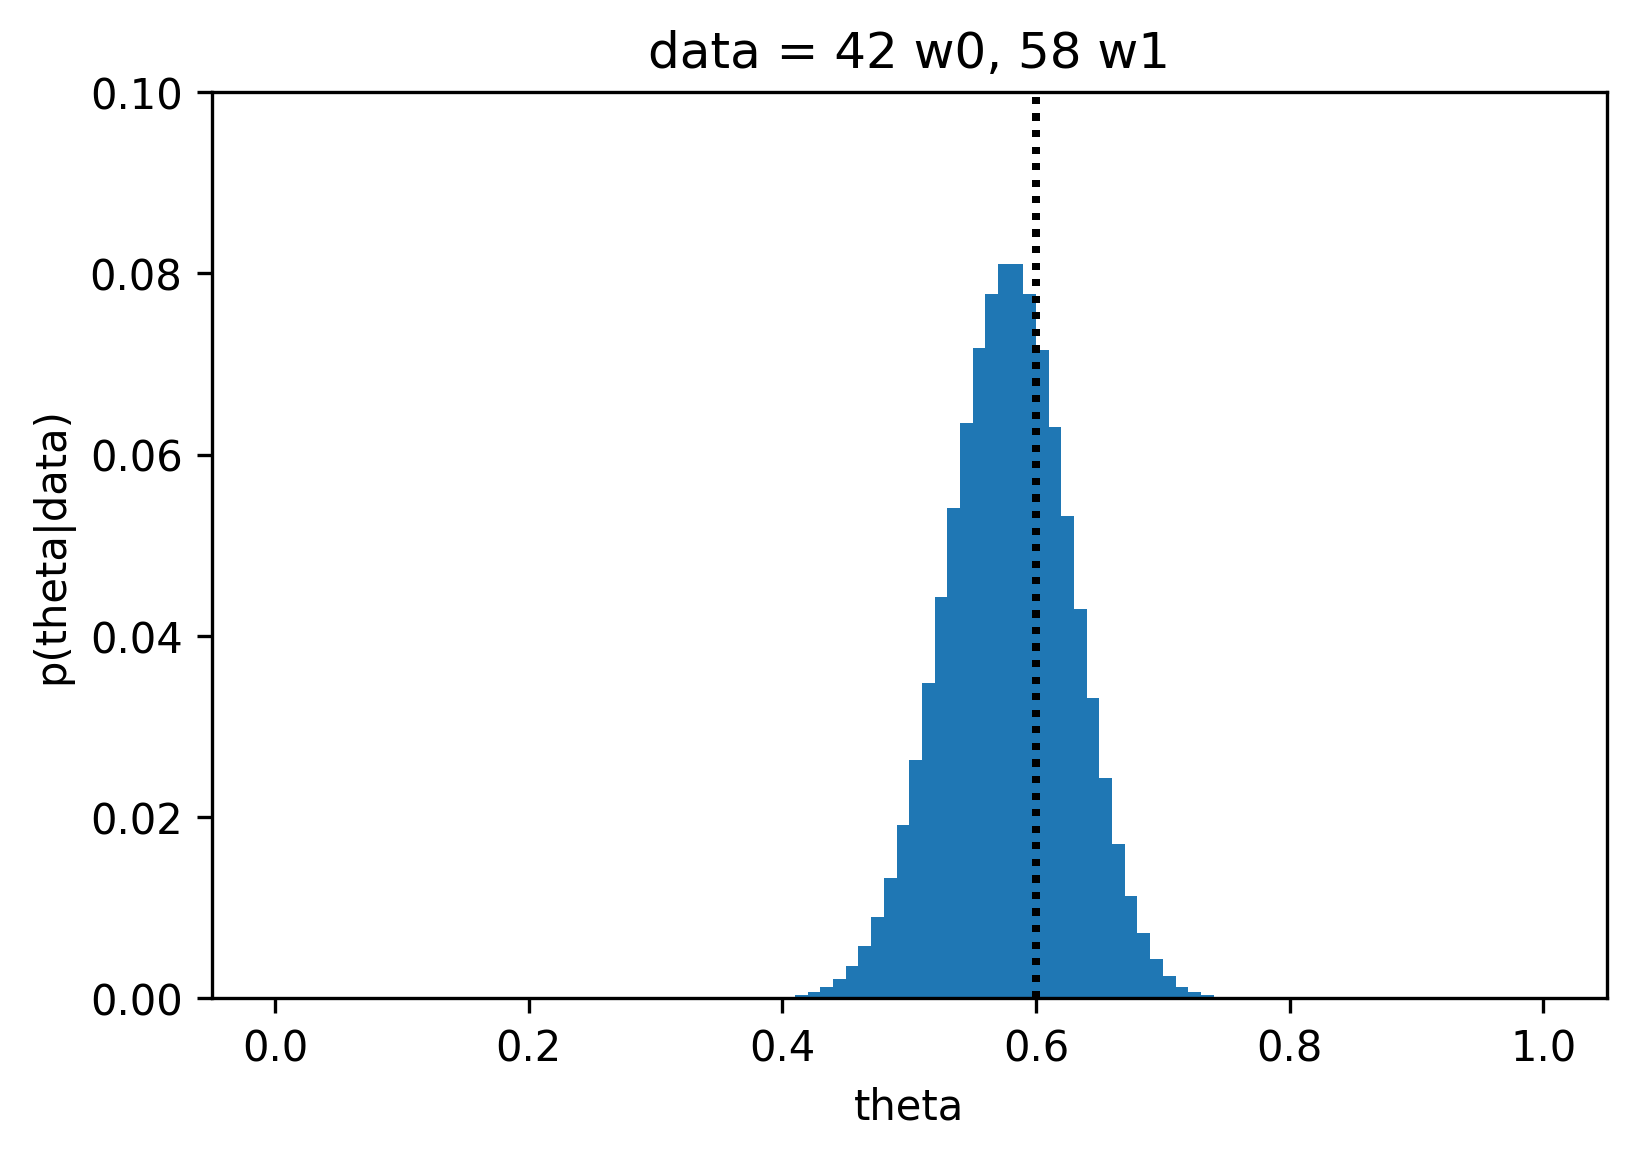

In [11]:
from matplotlib import animation

uniform_prior = calculate_logprior(1, possible_pW1)
fig=plt.figure(dpi=300)
#initialise 
barcollection = plt.bar(possible_pW1,
                        [exp(logp) for logp in logposterior(data[0],
                                                            uniform_prior,
                                                            possible_pW1)],
                        align='center',width=1./grid_granularity)

def animate(i):
    this_data = data[i]
    data_w1_count = sum(this_data)
    data_w0_count = len(this_data)-data_w1_count
    y=[exp(logp) for logp in logposterior(this_data,uniform_prior,possible_pW1)]
    for i, b in enumerate(barcollection):
        b.set_height(y[i])
    plt.xlabel("theta")
    plt.ylabel("p(theta|data)")
    plt.ylim([0,0.1])
    plt.title("data = " + str(data_w0_count) + " w0, "+ str(data_w1_count) + " w1")
    plt.axvline(x=0.6,color='black',linestyle=':')
    

anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=101,
                             interval=500)

anim.save('posterior_uniform.mp4',writer=animation.FFMpegWriter(fps=10,bitrate=300))
anim.save('posterior_uniform_SLOW.mp4',writer=animation.FFMpegWriter(fps=1,bitrate=300))

Loop and create matching images

In [13]:
for i in range(0,101):
    fig=plt.figure(dpi=300)
    this_data = data[i]
    data_w1_count = sum(this_data)
    data_w0_count = len(this_data)-data_w1_count
    y=[exp(logp) for logp in logposterior(this_data,uniform_prior, possible_pW1)]
    plt.bar(possible_pW1,y,align='center',width=1./grid_granularity)
    plt.xlabel("theta")
    plt.ylabel("p(theta|data)")
    plt.ylim([0,0.1])
    plt.title("data = " + str(data_w0_count) + " w0, "+ str(data_w1_count) + " w1")
    plt.axvline(x=0.6,color='black',linestyle=':')
    plt.savefig("Lecture4Plots/posterior_uniform_"+str(i)+".pdf")
    plt.close()


Same for the regularity prior, alpha=0.1. Note that I am using the identical data!

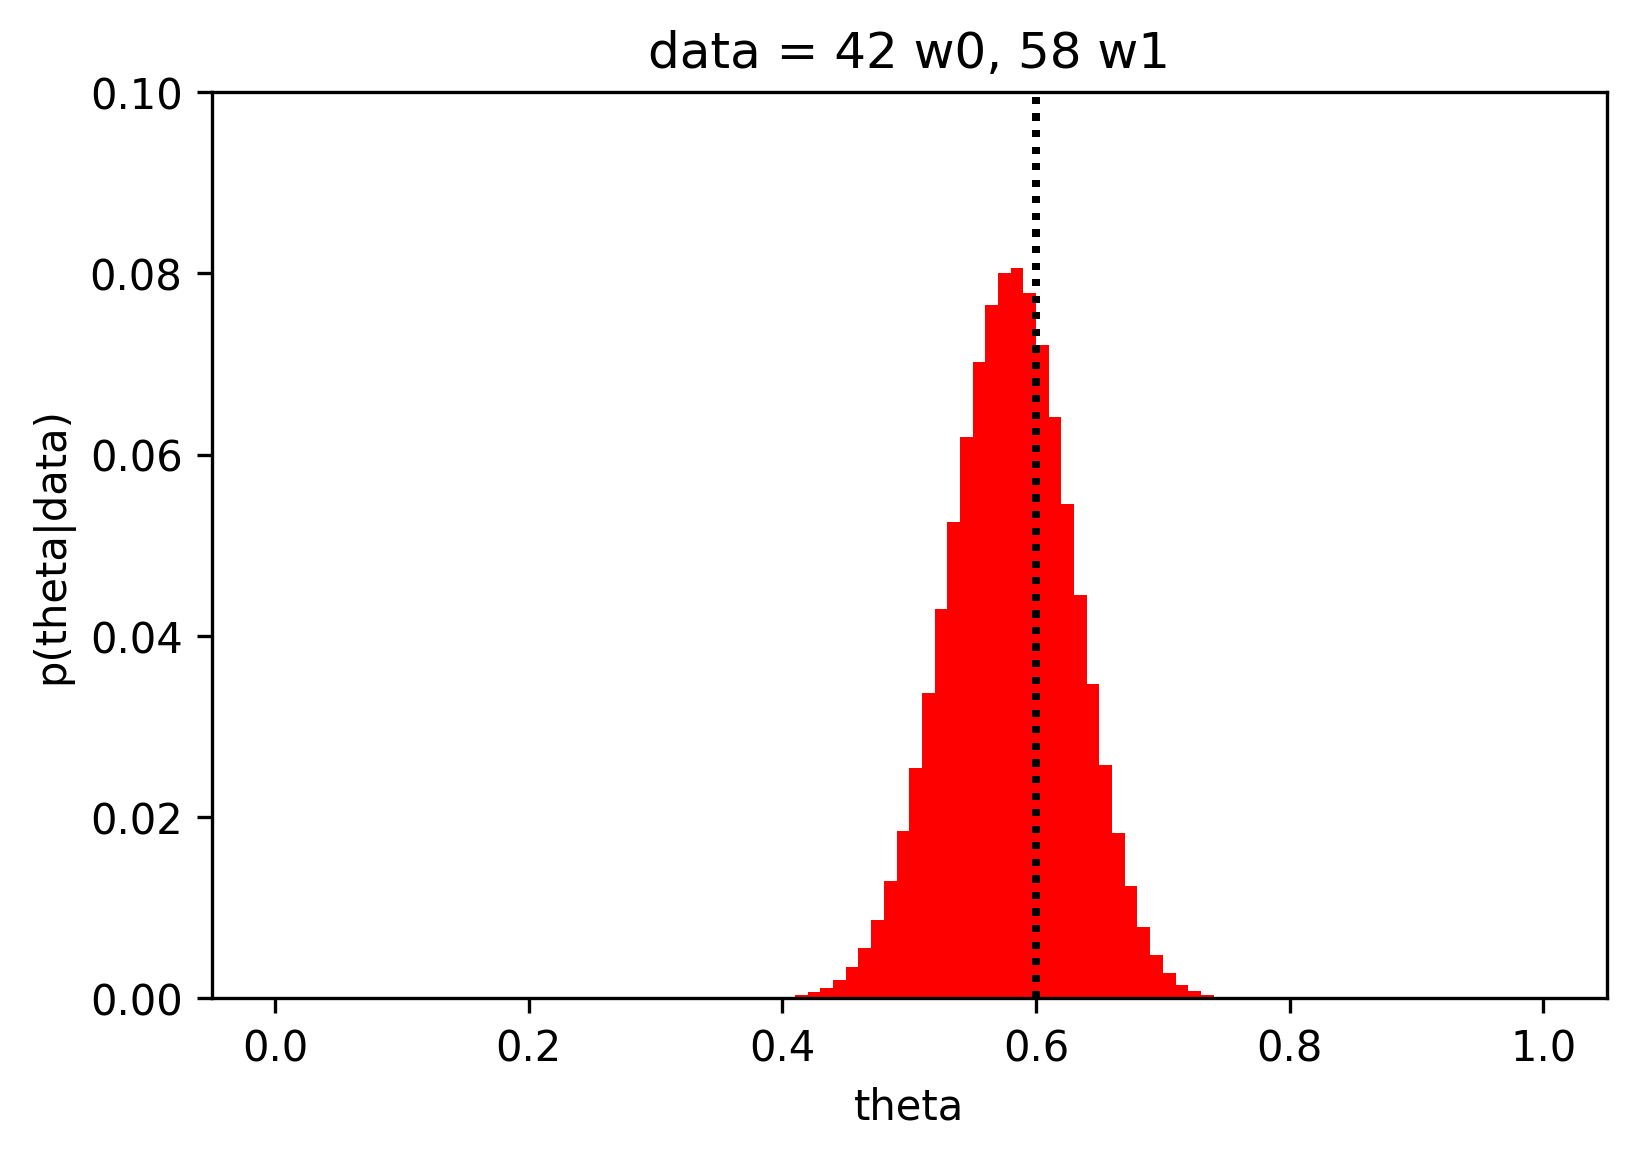

In [14]:
regularity_prior = calculate_logprior(0.1, possible_pW1)
fig=plt.figure(dpi=300)
#initialise 
barcollection = plt.bar(possible_pW1,[exp(logp) for logp in logposterior(data[0],
                                                                         regularity_prior,
                                                                        possible_pW1)],
                        align='center',width=1./grid_granularity,
                       color='red')

def animate(i):
    this_data = data[i]
    data_w1_count = sum(this_data)
    data_w0_count = len(this_data)-data_w1_count
    y=[exp(logp) for logp in logposterior(this_data,regularity_prior,possible_pW1)]
    for i, b in enumerate(barcollection):
        b.set_height(y[i])
    plt.xlabel("theta")
    plt.ylabel("p(theta|data)")
    plt.ylim([0,0.1])
    plt.title("data = " + str(data_w0_count) + " w0, "+ str(data_w1_count) + " w1")
    plt.axvline(x=0.6,color='black',linestyle=':')
    plt.savefig("Lecture4Plots/posterior_regularity_"+str(i)+".pdf")
    

anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=101,
                             interval=500)

anim.save('posterior_regularity.mp4',writer=animation.FFMpegWriter(fps=10,bitrate=300))
anim.save('posterior_regularity_SLOW.mp4',writer=animation.FFMpegWriter(fps=1,bitrate=300))

In [15]:
for i in range(0,101):
    fig=plt.figure(dpi=300)
    this_data = data[i]
    data_w1_count = sum(this_data)
    data_w0_count = len(this_data)-data_w1_count
    y=[exp(logp) for logp in logposterior(this_data,regularity_prior,possible_pW1)]
    plt.bar(possible_pW1,y,
            align='center',width=1./grid_granularity,color='red')
    plt.xlabel("theta")
    plt.ylabel("p(theta|data)")
    plt.ylim([0,0.1])
    plt.title("data = " + str(data_w0_count) + " w0, "+ str(data_w1_count) + " w1")
    plt.axvline(x=0.6,color='black',linestyle=':')
    plt.savefig("Lecture4Plots/posterior_regularity_"+str(i)+".pdf")
    plt.close()


Now I want to run a bunch of iterated learning chains - 10,000! - then collate the results and plot histograms.

In [16]:
nruns=10000
#do a bunch of runs and collate the data
uniform_simulation_data = []
for i in range(nruns):
    theta_values,_data = iterate(1,possible_pW1,10,6,10)
    uniform_simulation_data.append(theta_values)

Plot the histograms of values of theta at each generation and save.

In [17]:
for generation_to_plot in range(10):
    this_g_data = []
    for run in uniform_simulation_data:
        this_g_data.append(run[generation_to_plot])
    

    #now we can plot the data as before
    plt.figure()
    plt.hist(this_g_data,bins=10,color='blue')
    plt.xlabel('theta')
    plt.ylabel('Number of chains with this theta')
    plt.subplots_adjust(left=0.15)
    #plt.subplots_adjust(bottom=0.15)
    plt.axvline(x=0.6,color='black',linestyle=':')
    plt.title("Uniform prior, generation "+str(generation_to_plot+1))
    plt.xlim(0,1)
    plt.ylim(0,3500)
    plt.savefig("Lecture4Plots/iterate_uniform_"+str(generation_to_plot+1)+".pdf")
    plt.close()
!tar czf iterate_uniform.tar.gz Lecture4Plots/iterate_uniform_*
    

Same for regularity prior

In [18]:
nruns=10000
#do a bunch of runs and collate the data
regularity_simulation_data = []
for i in range(nruns):
    theta_values,_data = iterate(0.1,possible_pW1,10,6,10)
    regularity_simulation_data.append(theta_values)

In [19]:
for generation_to_plot in range(10):
    this_g_data = []
    for run in regularity_simulation_data:
        this_g_data.append(run[generation_to_plot])
    

    #now we can plot the data as before
    plt.figure()
    plt.hist(this_g_data,bins=10,color='r')
    plt.xlabel('theta')
    plt.ylabel('Number of chains with this theta')
    plt.subplots_adjust(left=0.15)
    #plt.subplots_adjust(bottom=0.15)
    plt.axvline(x=0.6,color='black',linestyle=':')
    plt.title("Regularity prior, generation "+str(generation_to_plot+1))
    plt.xlim(0,1)
    plt.ylim(0,3500)
    plt.savefig("Lecture4Plots/iterate_regular_"+str(generation_to_plot+1)+".pdf")
    plt.close()
!tar czf iterate_regularity.tar.gz Lecture4Plots/iterate_regular_*
    